In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt

from tabulate import tabulate
from IPython.display import HTML, display

In [2]:
eil51 = "problem_data/small/eil51.tsp.txt"
eil51_opt = "problem_data/small/eil51.opt.tour.txt"

a280 = "problem_data/big/a280.tsp.txt"
a280_opt = "problem_data/big/a280.opt.tour.txt"
pcb442 = "problem_data/big/pcb442.tsp.txt"
pcb442_opt = "problem_data/big/pcb442.opt.tour.txt"

In [91]:
class TravelingSalesmanSolver:
    def __init__(self,tsp_file,opt_tsp_file):
        self.nodes = self.read_tsp(tsp_file)
        self.dist_matrix = self.distance_matrix()
        self.optimal_tour = self.read_tsp_opt(opt_tsp_file) if opt_tsp_file else None

        self.opt_tour = 'No optimal tour calculated - run TravelingSalesmanSolver.simulated_annealing first!'
        self.opt_dist = 'Not optimal distance - run TravelingSalesmanSolver.simulated_annealing first!'

        self.steps_dict = {'iteration':[],'opt_distance':[]}
    
    def read_tsp(self,tsp_file):
        """Read the tsp file and create a list of the nodes coordinates"""
        with open(tsp_file, 'r') as f: lines = f.readlines()

        nodes = []
        for line in lines[lines.index('NODE_COORD_SECTION\n') + 1:lines.index('EOF\n')]: #Loop only through the lines of interest in the file
            _, x, y = map(float, line.split()) #Extract the x and y of the coordinates for each node/line
            nodes.append((x, y)) 
        return np.array(nodes)

    def read_tsp_opt(self,opt_tsp_file):
        """Read the opt tsp file and create a list of the nodes coordinates"""
        lines = open(opt_tsp_file, 'r').readlines() # Create a list of all the lines
        nodes = []

        for line in lines[lines.index('TOUR_SECTION\n') + 1:lines.index('-1\n') + 1]: #Loop only through the lines of interest in the file
            if int(line) != -1: #Other than the last line (which indicates to come back to the first node), deacrease the line-value by one to reflect python-indexes style
                nodes.append(int(line) - 1)

        return np.array(nodes) #Return the true optimal tour

    def distance_matrix(self):
        return np.linalg.norm(self.nodes[:, np.newaxis] - self.nodes, axis=2)     
    
    def tot_distance(self, tour):
        """Calculate the total distance of the tour.
        Sum the distancec between the nodes in the tour (in their order), plus the distance between the last and first node (the salesman must come back to the first node)"""
        return sum(self.dist_matrix[tour[i], tour[i+1]] for i in range(len(tour) - 1)) + self.dist_matrix[tour[-1], tour[0]]

    def two_opt(self, tour, i, k):
        """Perform two opt swap, reversing the segment of the tour between node i and node j"""
        return tour[:i] + tour[i:k+1][::-1] + tour[k+1:]
    
    def simulated_annealing(self, T0=1000, cooling_rate=0.995, mc_length=1000, max_iterations=10000):
        """Perform optimization of the total distance through simulated annealing"""

        # Create a random starting tour and calculate its total distance
        n = len(self.dist_matrix)
        present_tour = list(range(n))
        random.shuffle(present_tour)

        present_dist = self.tot_distance(present_tour)
        
        # Set the best-so-far tour and distance to the random one just created
        opt_tour = present_tour[:]
        opt_dist = present_dist
        T = T0

        for iteration in range(max_iterations):
            for _ in range(mc_length): # Loop through a markov chain before updating the temperature
                i, k = sorted(random.sample(range(n), 2)) # Randomly pick i and j (such that i<j) to perform two opt
                new_tour = self.two_opt(present_tour, i, k)
                new_dist = self.tot_distance(new_tour)  # Calculate the total distance of this new tour
                
                 # If the new distance is lower that the best-so-far one or a random number is lower than the temperature-based parameter computed below (set to be maximum = 1), focus on the new tour found
                if new_dist < present_dist or random.random() <= min(math.exp((present_dist - new_dist) / T), 1):
                    present_tour, present_dist = new_tour, new_dist
                    if present_dist < opt_dist: #Update the estimates if this new tour is shorter that the best-so-far
                        opt_tour, opt_dist = present_tour[:], present_dist
                
            T *= cooling_rate # Upgrade the temperature according the cooling rate
            if T < 1e-12: # Break the loop if the temperature becomes too small
                break

            #Save value at that iteration
            self.steps_dict['iteration'].append(iteration)
            self.steps_dict['opt_distance'].append(opt_dist)
        
        #Set and return solutions
        self.opt_tour = opt_tour
        self.opt_dist = opt_dist

        return opt_tour, opt_dist
    
    def get_iters(self):
        return self.steps_dict
    
    def opt_distance(self):
       if self.optimal_tour is not None:
            return (self.tot_distance(self.optimal_tour))
    
    def show_results(self):
        table = [ 
            ["Shortest Found Tour Distance", self.opt_dist]
        ]
        
        if self.optimal_tour is not None:
            self.optimal_distance = self.opt_distance()
            table.append(["Optimal Tour Distance", self.optimal_distance])
            table.append(["Difference", self.opt_dist - self.optimal_distance])
        
        table.append([None,None])
        table.append(["Shortest Found Tour",self.opt_tour])
        
        return tabulate(table, headers=["Metric","Values"], tablefmt="html")   

In [81]:
# Instantiate solver with files
eil51_solver = TravelingSalesmanSolver(eil51,eil51_opt)

# Solve using func default parameters:
# T0 = 1000,cooling_rate = 0.995, mc_length = 1000, max_iterations = 10000
opt_tour, opt_distance = eil51_solver.simulated_annealing(max_iterations=10000)

#Show Final solutions
display(HTML(eil51_solver.show_results()))

Metric,Values
Shortest Tour Distance,433.2453184809248
Optimal Tour Distance,429.98331198338406
Difference,3.262006497540767
,
Shortest Tour,"[9, 38, 29, 33, 20, 28, 1, 19, 34, 35, 2, 27, 30, 25, 7, 21, 0, 31, 10, 15, 49, 8, 48, 37, 4, 36, 16, 3, 17, 46, 11, 45, 50, 26, 5, 47, 22, 6, 42, 23, 13, 24, 12, 40, 18, 39, 41, 43, 14, 44, 32]"


In [82]:
# Read the file, calculate the data of the problem (nodes coordinates and distance matrix)
a280_solver = TravelingSalesmanSolver(a280,a280_opt)

# Solve using func default parameters except:
# cooling_rate = 0.9993, mc_length = 500, and max_iterations = 10000
opt_tour, opt_distance = a280_solver.simulated_annealing(cooling_rate=0.9993,mc_length=500,max_iterations=10000)

#Show Final solutions
a280_solver.show_results()

Metric,Values
Shortest Tour Distance,2712.573878039118
Optimal Tour Distance,2586.7696475631606
Difference,125.80423047595741
,
Shortest Tour,"[230, 245, 250, 229, 228, 227, 226, 225, 224, 223, 222, 218, 221, 220, 219, 216, 217, 214, 215, 212, 211, 213, 210, 209, 208, 251, 252, 207, 206, 205, 204, 203, 202, 143, 144, 198, 199, 201, 200, 197, 196, 195, 194, 193, 192, 191, 190, 189, 188, 187, 186, 185, 184, 183, 182, 181, 180, 179, 178, 175, 176, 177, 149, 148, 147, 146, 145, 142, 141, 140, 139, 265, 138, 137, 136, 135, 134, 133, 132, 17, 18, 131, 130, 19, 20, 129, 128, 127, 126, 125, 124, 123, 122, 121, 120, 119, 153, 154, 152, 155, 151, 150, 118, 156, 157, 158, 159, 174, 160, 161, 162, 163, 164, 165, 166, 167, 99, 98, 100, 168, 169, 171, 170, 172, 173, 106, 105, 104, 103, 107, 109, 110, 111, 87, 82, 81, 78, 79, 80, 88, 108, 89, 90, 102, 101, 91, 92, 97, 96, 93, 95, 94, 77, 76, 75, 74, 73, 72, 71, 70, 69, 66, 68, 67, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 58, 62, 63, 65, 64, 84, 83, 86, 85, 115, 112, 113, 114, 116, 117, 61, 60, 59, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 21, 24, 22, 23, 16, 15, 269, 268, 267, 266, 264, 263, 262, 261, 260, 259, 258, 257, 256, 253, 254, 255, 248, 249, 247, 277, 276, 275, 274, 273, 272, 271, 270, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 278, 2, 279, 0, 1, 241, 242, 240, 243, 246, 244, 239, 238, 237, 236, 235, 234, 233, 232, 231]"


In [83]:
# Read the file, calculate the data of the problem (nodes coordinates and distance matrix)
pcb442_solver = TravelingSalesmanSolver(pcb442,pcb442_opt)

# Solve using func default parameters except:
# cooling_rate = 0.9993, mc_length = 500, and max_iterations = 10000
opt_tour, opt_distance = pcb442_solver.simulated_annealing(cooling_rate=0.9993,mc_length=500,max_iterations=10000)

#Show Final solutions
pcb442_solver.show_results()

Metric,Values
Shortest Tour Distance,53220.27527196616
Optimal Tour Distance,50783.54751373533
Difference,2436.7277582308307
,
Shortest Tour,"[121, 109, 110, 122, 132, 145, 157, 168, 181, 182, 169, 158, 146, 133, 123, 111, 435, 100, 92, 93, 94, 378, 95, 379, 96, 64, 31, 375, 376, 32, 97, 383, 382, 112, 124, 134, 147, 159, 170, 183, 198, 209, 219, 225, 236, 264, 413, 409, 410, 218, 208, 197, 196, 195, 194, 205, 206, 207, 217, 235, 262, 263, 415, 267, 419, 271, 437, 422, 274, 436, 306, 333, 334, 335, 426, 336, 337, 374, 373, 372, 371, 370, 431, 369, 368, 367, 366, 365, 364, 344, 328, 329, 330, 331, 332, 305, 304, 303, 302, 327, 326, 301, 300, 299, 298, 297, 296, 295, 277, 294, 293, 319, 320, 321, 322, 429, 323, 428, 324, 325, 430, 363, 362, 361, 343, 360, 359, 358, 434, 357, 356, 355, 433, 354, 353, 352, 342, 351, 350, 349, 348, 432, 338, 347, 346, 345, 341, 340, 427, 281, 280, 278, 275, 272, 269, 268, 265, 237, 238, 233, 226, 404, 399, 184, 171, 160, 148, 135, 125, 113, 102, 440, 385, 126, 136, 149, 150, 151, 391, 137, 115, 388, 386, 114, 103, 101, 65, 33, 441, 0, 1, 2, 3, 36, 35, 34, 66, 67, 68, 69, 70, 38, 37, 4, 5, 6, 7, 40, 39, 71, 72, 73, 41, 8, 9, 10, 11, 12, 45, 44, 43, 42, 74, 75, 76, 98, 77, 78, 79, 80, 99, 106, 117, 105, 104, 116, 127, 138, 139, 152, 392, 162, 175, 187, 199, 212, 221, 229, 248, 247, 246, 245, 244, 243, 242, 241, 240, 228, 220, 211, 402, 210, 174, 186, 398, 395, 173, 161, 172, 185, 400, 405, 227, 406, 234, 239, 266, 270, 273, 276, 425, 279, 439, 307, 308, 282, 283, 309, 310, 284, 285, 286, 312, 311, 339, 313, 314, 315, 316, 317, 318, 292, 291, 290, 289, 288, 287, 423, 420, 424, 414, 249, 250, 251, 416, 417, 252, 253, 254, 255, 256, 257, 258, 259, 418, 421, 261, 260, 412, 411, 407, 408, 403, 216, 204, 193, 180, 167, 156, 144, 131, 390, 143, 142, 155, 393, 166, 179, 192, 191, 203, 215, 224, 232, 231, 223, 214, 202, 190, 397, 178, 394, 165, 177, 189, 201, 401, 230, 222, 213, 200, 188, 176, 396, 163, 164, 153, 140, 128, 154, 141, 389, 387, 129, 118, 107, 438, 81, 82, 50, 49, 48, 47, 46, 13, 14, 15, 16, 17, 18, 51, 52, 19, 20, 21, 22, 23, 24, 25, 58, 26, 27, 28, 29, 30, 63, 62, 61, 60, 59, 91, 90, 89, 57, 88, 56, 55, 87, 377, 86, 54, 53, 85, 84, 83, 380, 381, 108, 119, 130, 384, 120]"


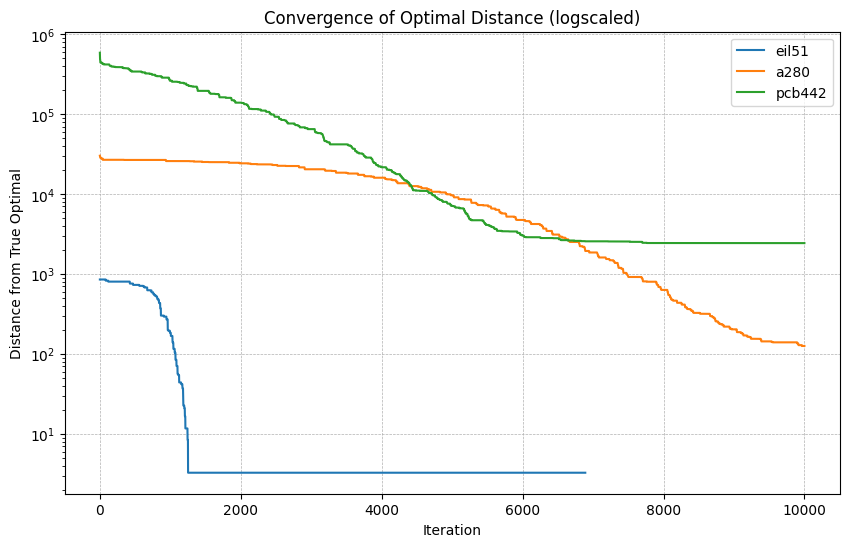

In [92]:
def convergence_rate(convergence_path, optimal_distance):
    # Calculate the differences from optimal distance
    dist = np.array(convergence_path['opt_distance'])
    return dist - optimal_distance

def plot_ROC(convergence_path, optimal_value, label):
    iterations = np.array(convergence_path['iteration'])
    distances = convergence_rate(convergence_path, optimal_value)
    plt.plot(iterations, distances, label=label, zorder=5)

# Plot setup
plt.figure(figsize=(10, 6))
plt.yscale('log')
plot_ROC(eil51_solver.get_iters(), eil51_solver.optimal_distance, 'eil51')
plot_ROC(a280_solver.get_iters(), a280_solver.optimal_distance, 'a280')
plot_ROC(pcb442_solver.get_iters(), pcb442_solver.optimal_distance, 'pcb442')
plt.xlabel('Iteration')
plt.ylabel('Distance from True Optimal')
plt.title('Convergence of Optimal Distance (logscaled)')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

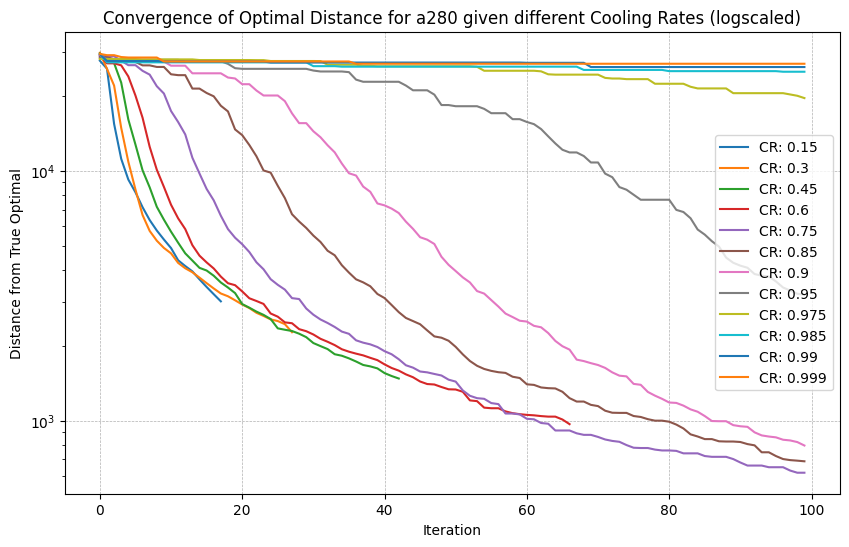

In [98]:
# Exploring the affects of different cooling rates
cooling_rates = [0.15,0.30,0.45,0.60,0.75,0.85,0.90,0.95,0.975,0.985,0.99,0.999]

plt.figure(figsize=(10, 6))

results = {'cooling_rate':[],'iterations':[],'distance':[]}
for cr in cooling_rates:
    # Read the file, calculate the data of the problem (nodes coordinates and distance matrix)
    solver = TravelingSalesmanSolver(a280,a280_opt) #testing on a280 (medium) problem

    opt_tour, opt_distance = solver.simulated_annealing(cooling_rate=cr,max_iterations=1000)
    plot_ROC(solver.get_iters(),solver.opt_distance(),f'CR: {cr}')

    #Graph convergence solution
    solver.show_results()

plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Distance from True Optimal')
plt.title('Convergence of Optimal Distance for a280 given different Cooling Rates (logscaled)')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()